In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math

### Helper functions

In [2]:
def grayscale(img):    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
       
def convert_hls(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
            
    cv2.fillPoly(mask, vertices, ignore_mask_color)
        
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, houghLines, color=[0, 255, 0], thickness=2):
    for line in houghLines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    houghLines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, houghLines)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

def mask_white_yellow(image):
    converted = convert_hls(image)
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    whiteYellowImage = cv2.bitwise_and(image, image, mask = mask)
    return whiteYellowImage

aLeftStored = 0
aRightStored = 0
bLeftStored = 0
bRightStored = 0
yMinStored = 0

def reset_params_for_averaging():
    global aLeftStored
    global bLeftStored
    global aRightStored
    global bRightStored   
    global yMinStored
    
    aLeftStored = 0
    aRightStored = 0
    bLeftStored = 0
    bRightStored = 0
    yMinStored = 0

def get_averaged_line_params(lineParams, leftHoughLinesExist, rightHoughLinesExist):
    global aLeftStored
    global bLeftStored
    global aRightStored
    global bRightStored    

    param1 = 0.9
    param2 = 0.1

    a_left = lineParams[0]
    b_left = lineParams[1]
    a_right = lineParams[2]
    b_right = lineParams[3]

    if (aLeftStored==0):
        aLeftStored = a_left   
    if (bLeftStored==0):
        bLeftStored = b_left
    if (aRightStored==0):
        aRightStored = a_right
    if (bRightStored==0):
        bRightStored = b_right
        
    if (not leftHoughLinesExist):
        a_left = aLeftStored
    else :
        a_left = aLeftStored * param1 + a_left * param2
        aLeftStored = a_left
        b_left = bLeftStored * param1 + b_left * param2
        bLeftStored = b_left
     
    if (not rightHoughLinesExist):
        a_right = aRightStored
    else : 
        a_right = aRightStored * param1 + a_right * param2
        aRightStored = a_right
        b_right = bRightStored * param1 + b_right * param2
        bRightStored = b_right

    return [a_left, b_left, a_right, b_right]

def get_top_y_point(lineParams, y_min):
    global yMinStored
    param1 = 0.9
    param2 = 0.1

    a_left = lineParams[0]
    b_left = lineParams[1]
    a_right = lineParams[2]
    b_right = lineParams[3]

    yIntersection = int((a_right*b_left-a_left*b_right)/(a_right-a_left))
    margin = 10
    if (yIntersection + margin > y_min):   
        y_min = yIntersection + margin        

    if (yMinStored==0):
        yMinStored = y_min    
    y_min = int(yMinStored * param1 + y_min * param2)
    yMinStored = y_min   
    return y_min

### Main processing pipeline

In [3]:
def draw_lanes_image(imageName):
    image = mpimg.imread(imageName)
    reset_params_for_averaging()
    draw_lanes(image, True, imageName)

def draw_lanes(image, showIntermediateSteps=False, imageName=""):
    imgHeight = image.shape[0]
    imgWidth = image.shape[1]

    whiteYellowImage = mask_white_yellow(image)
    grayImage = grayscale(whiteYellowImage)
    blurredImage = gaussian_blur(grayImage, 5)
    edgesImage = canny(blurredImage, 40, 80)
    yTopMask = imgHeight*0.55
    vertices = np.array([[0, imgHeight], [imgWidth*0.45, yTopMask], [imgWidth*0.55, yTopMask], [imgWidth,imgHeight]], np.int32)
    maskedImage = region_of_interest(edgesImage, [vertices])
       

    rho = 2
    theta = np.pi/180
    threshold = 15	
    min_line_length = 15
    max_line_gap = 5

    houghLines = cv2.HoughLinesP(maskedImage, rho, theta, threshold, np.array([]), minLineLength=min_line_length, maxLineGap=max_line_gap)

    if (showIntermediateSteps):
        houghLinesImage = np.zeros((imgHeight, imgWidth, 3), dtype=np.uint8)    
        draw_lines(houghLinesImage, houghLines)
        origWithHoughLines = weighted_img(houghLinesImage,image)

       
    linesFiltered = []    
    cumLengthLeft = 0
    cumLengthRight = 0
    leftHoughLinesExist = False;
    rightHoughLinesExist = False;
    a_left = 0
    b_left = 0
    a_right = 0
    b_right = 0
    y_min = 10000
                
    for line in houghLines:
        for x1,y1,x2,y2 in line:
            if (y1<y_min):
                y_min = y1
            if (y2<y_min):
                y_min = y2
            a = float((y2-y1)/(x2-x1))
            b = (y1-a*x1)      
            length = math.sqrt(pow(y2-y1,2)+pow(x2-x1,2))
           
            if not np.isnan(a) or np.isinf(a) or (a == 0):
                if (a > -1.5) and (a < -0.3) :
                    linesFiltered.append(line) 
                    cumLengthLeft += pow(length,2)
                    leftHoughLinesExist = True
                    a_left += a * pow(length,2)
                    b_left += b * pow(length,2)

                if (a > 0.3) and (a < 1.5) :
                    linesFiltered.append(line)                   
                    cumLengthRight += pow(length,2)
                    rightHoughLinesExist = True
                    a_right += a * pow(length,2)
                    b_right += b * pow(length,2)
                   
    if (showIntermediateSteps):
        houghLinesFilteredImage = np.zeros((imgHeight, imgWidth, 3), dtype=np.uint8)
        draw_lines(houghLinesFilteredImage, linesFiltered)
        origWithHoughLinesFiltered = weighted_img(houghLinesFilteredImage,image)  
    
    if (y_min==10000):
        y_min = yTopMask
    
    y_max = imgHeight
    
    if (cumLengthLeft != 0) :                     
        a_left /= cumLengthLeft    
        b_left /= cumLengthLeft    
     
    if (cumLengthRight != 0)  :
        a_right /= cumLengthRight
        b_right /= cumLengthRight
    
    lineParams = [a_left, b_left, a_right, b_right]
    lineParams = get_averaged_line_params(lineParams, leftHoughLinesExist, rightHoughLinesExist)

    y_min = get_top_y_point(lineParams, y_min)
    
    x1_left = 0
    x2_left = 0
    x1_right = 0
    x2_right = 0 
    
    a_left = lineParams[0]
    b_left = lineParams[1]
    a_right = lineParams[2]
    b_right = lineParams[3]
    
    if (a_left!=0):    
        x1_left = int((y_max-b_left)/a_left)
        x2_left = int((y_min-b_left)/a_left)
    
    if (a_right!=0): 
        x1_right = int((y_max-b_right)/a_right)
        x2_right = int((y_min-b_right)/a_right)
    
    foundLinesImage = np.zeros((imgHeight, imgWidth, 3), dtype=np.uint8)
       
    if (a_left!=0):    
        cv2.line(foundLinesImage, (x1_left, y_max), (x2_left, y_min), [255, 0, 0], 7)
    
    if (a_right!=0): 
        cv2.line(foundLinesImage, (x1_right, y_max), (x2_right, y_min), [255, 0, 0], 7)
    
    origWithFoundLanes = weighted_img(foundLinesImage,image)
    
    if (showIntermediateSteps):    
#        imgName = imageName[imageName.index("/")+1:-4]        
#        cv2.imwrite("output_images/"+imgName+"_1_original.jpg",cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#        cv2.imwrite("output_images/"+imgName+"_2_whiteYellowImage.jpg",cv2.cvtColor(whiteYellowImage, cv2.COLOR_BGR2RGB))
#        cv2.imwrite("output_images/"+imgName+"_3_grayImage.jpg",grayImage)
#        cv2.imwrite("output_images/"+imgName+"_4_blurredImage.jpg",blurredImage)
#        cv2.imwrite("output_images/"+imgName+"_5_edgesImage.jpg",edgesImage)
#        cv2.imwrite("output_images/"+imgName+"_5_maskedImage.jpg",maskedImage)
#        cv2.imwrite("output_images/"+imgName+"_6_origWithHoughLines.jpg",cv2.cvtColor(origWithHoughLines, cv2.COLOR_BGR2RGB))
#        cv2.imwrite("output_images/"+imgName+"_7_origWithHoughLinesFiltered.jpg",cv2.cvtColor(origWithHoughLinesFiltered, cv2.COLOR_BGR2RGB))
#        cv2.imwrite("output_images/"+imgName+"_8_origWithFoundLanes.jpg",cv2.cvtColor(origWithFoundLanes, cv2.COLOR_BGR2RGB))
    
        fig = plt.figure(figsize = (30,20))
        plt.subplot(131)
        plt.imshow(image)
        plt.subplot(132)
        plt.imshow(whiteYellowImage)
        plt.subplot(133)
        plt.imshow(grayImage, cmap='gray')
        
        fig2 = plt.figure(figsize = (30,20))
        plt.subplot(131)
        plt.imshow(blurredImage, cmap='gray')       
        plt.subplot(132)
        plt.imshow(edgesImage, cmap='gray')
        plt.subplot(133)
        plt.imshow(maskedImage, cmap='gray')
        
        fig3 = plt.figure(figsize = (30,20))       
        plt.subplot(131)
        plt.imshow(origWithHoughLines)
        plt.subplot(132)
        plt.imshow(origWithHoughLinesFiltered)
        plt.subplot(133)
        plt.imshow(origWithFoundLanes)           
        
        plt.show()
    
    return origWithFoundLanes                    
                        

### Testing on images

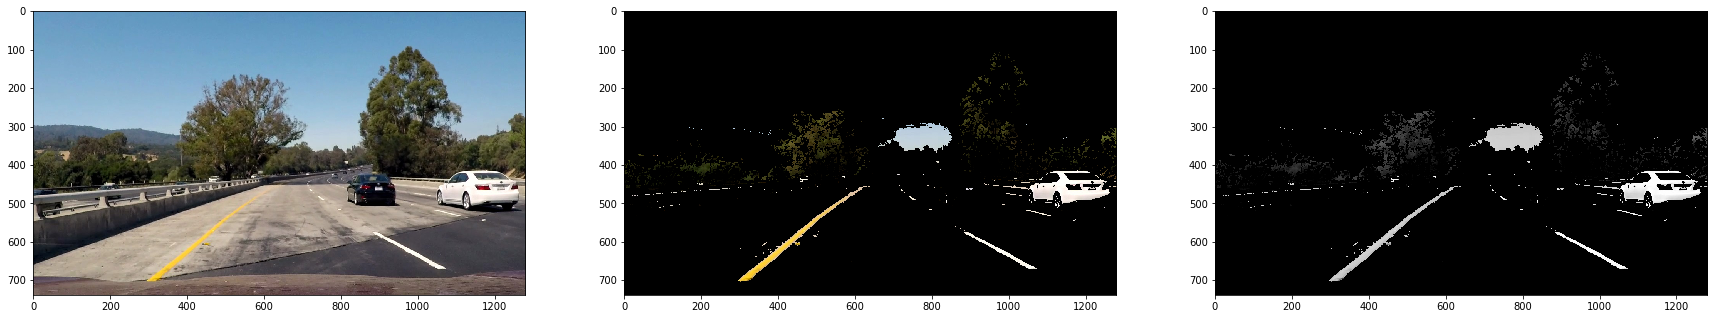

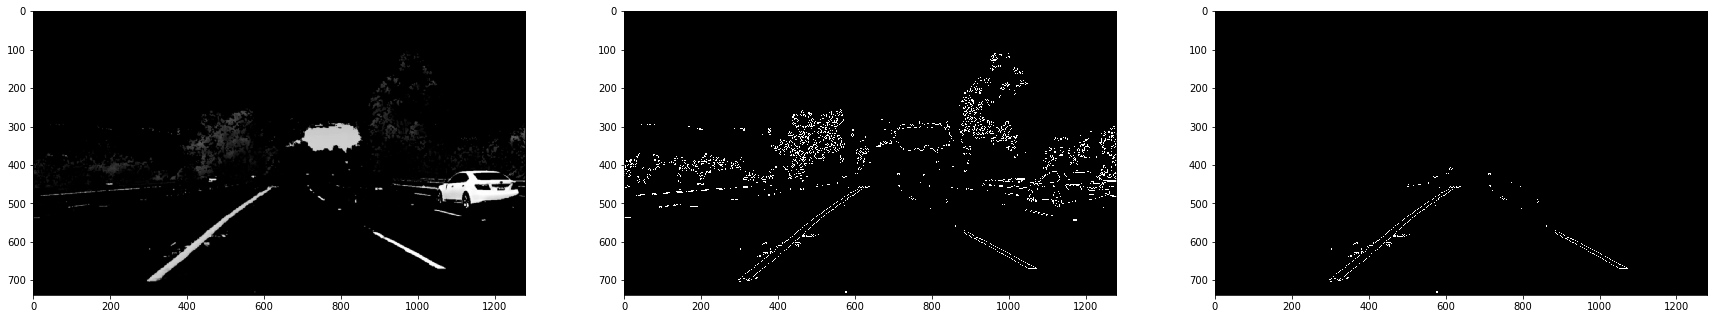

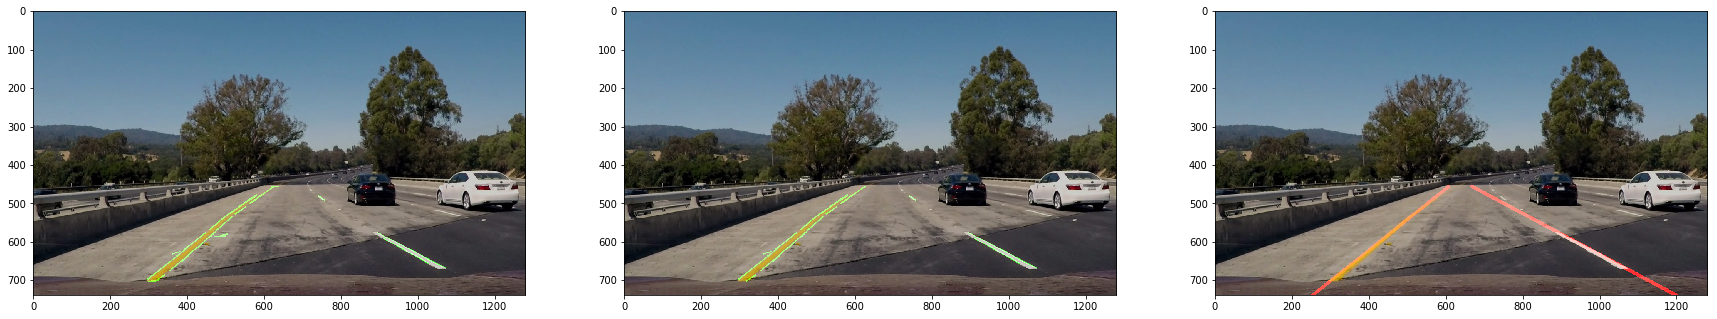

In [4]:
#import os
#for img in os.listdir("test_images/"):
#   draw_lanes_image("test_images/"+img)

draw_lanes_image("test_images/challengeSnap3.jpg")

### Testing on video files

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#output = 'output_movies/solidWhiteRight_out.mp4'
#clip1 = VideoFileClip("test_movies/solidWhiteRight.mp4")

#output = 'output_movies/solidYellowLeft_out.mp4'
#clip1 = VideoFileClip("test_movies/solidYellowLeft.mp4")

output = 'output_movies/challenge_out.mp4'
clip1 = VideoFileClip("test_movies/challenge.mp4")

reset_params_for_averaging()
clip_out = clip1.fl_image(draw_lanes) #NOTE: this function expects color images!!
from IPython import get_ipython
get_ipython().magic('time clip_out.write_videofile(output, audio=False)')

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))